In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt 
from matplotlib.patches import Rectangle
from IPython.display import Image, display
import pandas as pd

In [2]:
variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age','final_dens','init_dens','init_lat']

#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age','final_dens','init_dens','init_lat']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = xr.DataArray(age)
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var      

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)


def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

In [3]:
def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec)/time,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

In [4]:
def plotCS_NW(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1 #actually lon
    fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
    tmask = mesh.tmask[0]
    
    lons = data.init_lat[(data.final_section != 0)]
    
    f_lons = mesh.gphif[0,:, latgridf]
    u_lons = mesh.gphiv[0,:, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec)/time,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Latitude (°W)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

## Import data

In [5]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [6]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# files = ['forpr_ros3','forpr_haro3','forvs_haro3']
files = ['forpr_sjc3','forgulf_sjc3','forvs_sjc3','foradm_sjc3']
namen = ['datafvs']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6,7,8]

date = dt.datetime(2018,1,1)
enddate = dt.datetime(2018,12,27)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/' + date + '_s1t50/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        
    dicts[file] = dict_i
    
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for var in dicts[file].keys():
        if var not in st_dict:
            st_dict[var] = []
        for section in sectionnum:
            st_dict[var].append(get_datat(dicts[file][var],section,starttime,endtime))
        dict_sectiontransp[file] = st_dict

dict_age = {}

for file in files:
    a_dict = {}
    
    for date in dicts[file].keys():
        if date not in a_dict:
            a_dict[date] = []
        for section in sectionnum:
            allvar = get_secdata(dicts[file][date],section)
            a_dict[date].append(np.mean(allvar['final_age'][allvar['final_age']>=24]))
    dict_age[file] = a_dict

age_2018 = {}

for file in files:
    
    if file not in age_2018:
        age_2018[file] = {}
    
    for section in sectionnum:
        
        if section not in age_2018[file]:
            
            age_2018[file][section] = []
            
        for date in dicts[file].keys():
            
            age_2018[file][section].append(dict_age[file][date][section])
            
transp_2018 = {}

for file in files:
    
    transp_2018[file] = []
    
    for date in dates:
        try:
            transp_2018[file].append(np.sum(dict_sectiontransp[file][date][2:]))
        except:
            pass
        
sectransp_2018 = {}

for file in files:
    sectransp_2018[file] = {}
    
    for section in sectionnum:
        if section not in sectransp_2018[file]:
            sectransp_2018[file][section] = []
            
        for date in dates:
            try:
                sectransp_2018[file][section].append(dict_sectiontransp[file][date][section])
            except:
                pass

In [7]:
dict_secdata = {}

for file in files:
    
    if file not in dict_secdata:
        dict_secdata[file] = {}
    
    for section in sectionnum:
        
        if section not in dict_secdata[file]:
            
            dict_secdata[file][section] = {}
            
        for date in dicts[file].keys():
            
            dict_secdata[file][section][date] = get_secdata(dicts[file][date],section)

In [8]:
dataVStoPR_haro = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forVStoPR_haro/01jan18_s1t35/ariane_positions_quantitative.nc')
dataVStoPR_haro07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forVStoPR_haro/01jul18_s1t35/ariane_positions_quantitative.nc')
dataVStoPR_ros = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forVStoPR_ros/for_straight_01jan18_s1t35/ariane_positions_quantitative.nc')
dataVStoPR_ros07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forVStoPR_ros/for_straight_01mar18_s1t35/ariane_positions_quantitative.nc')
dataVStoPR_sjc = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forVStoPR_sjc/for_straight_01jan18_s1t35/ariane_positions_quantitative.nc')
datafPR_haro = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forPR_haro/01jan18_s1t35/ariane_positions_quantitative.nc')
datafPR_ros = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_ros/for_straight_01jan18_s1t35/ariane_positions_quantitative.nc')
datafPR_sjc = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_sjc/for_straight_01jan18_s1t35/ariane_positions_quantitative.nc')
databPR_ros = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backpr_ros/for_straight_01jan18_s1t35/ariane_positions_quantitative.nc')

datafPR_ros2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_ros2/for_straight_01jan18_s1t50/ariane_positions_quantitative.nc') #ros2 has boundary at SJCEast
datafPR_ros3 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_ros3/for_straight_01jan18_s1t50/ariane_positions_quantitative.nc')
datafPR_ros07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_ros/for_straight_01jul18_s1t35/ariane_positions_quantitative.nc')
datafPR_ros307 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_ros3/for_straight_01jul18_s1t50/ariane_positions_quantitative.nc')
datafPR_haro2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_haro2/for_straight_01jan18_s1t50/ariane_positions_quantitative.nc')
datafPR_haro207 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_haro2/for_straight_01jul18_s1t50/ariane_positions_quantitative.nc')
datafPR_sjc2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_sjc2/for_straight_01jan18_s1t50/ariane_positions_quantitative.nc')
datafPR_sjc207 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_sjc2/for_straight_01jul18_s1t50/ariane_positions_quantitative.nc')

data_dict = {'dataVStoPR_haro':dataVStoPR_haro,'dataVStoPR_ros':dataVStoPR_ros,'dataVStoPR_haro07':dataVStoPR_haro07,'dataVStoPR_ros07':dataVStoPR_ros07,'dataVStoPR_sjc':dataVStoPR_sjc,
             'datafPR_ros':datafPR_ros,'datafPR_sjc':datafPR_sjc,'datafPR_haro':datafPR_haro,'databPR_ros':databPR_ros,'datafPR_ros2':datafPR_ros2,'datafPR_ros07':datafPR_ros07,'datafPR_haro2':datafPR_haro2,
             'datafPR_haro207':datafPR_haro207,'datafPR_ros3':datafPR_ros3,'datafPR_ros307':datafPR_ros307,'datafPR_sjc2':datafPR_sjc2,'datafPR_sjc207':datafPR_sjc207
             }


In [9]:
ddd = {}
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']



for file in files:
    if file not in ddd:
        ddd[file] = {}
    
    for var in dict_secdata[file][section][date].keys():
    
        if var not in ddd[file]:
            ddd[file][var] = {}
        
        for section in sectionnum:
        
            if section not in ddd[file][var]:
            
                ddd[file][var][section] = {}
            
            for month in range(len(months)):
            
                if months[month] not in ddd[file][var][section]:
                    ddd[file][var][section][months[month]] = []

                for ii,date in enumerate(dicts[file].keys()):
                    
                    if datelist_vs[ii].month == month+1:
                        ddd[file][var][section][months[month]].extend(dict_secdata[file][section][date][var].values.tolist())
        

In [10]:
# #Importing data and calculating section transport 
# import warnings
# warnings.filterwarnings('ignore', category=RuntimeWarning)
# months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

# ddd = {}

# for ii,date in enumerate(dicts['forpr_haro3'].keys()):
    
#     for file in files:
#         if file not in ddd:
#             ddd[file] = {}
    
#         for var in dict_secdata[file][section][date].keys():
    
#             if var not in ddd[file]:
#                 ddd[file][var] = {}
        
#             for section in sectionnum:
        
#                 if section not in ddd[file][var]:
            
#                     ddd[file][var][section] = {}
            
#                 for month in range(len(months)):
            
#                     if months[month] not in ddd[file][var][section]:
#                         ddd[file][var][section][months[month]] = []
                    
#                     if datelist_vs[ii].month == month+1:
#                         ddd[file][var][section][months[month]].extend(dict_secdata[file][section][date][var].values.tolist())

In [ ]:
# Combining all months into 1 array

file = 'forpr_ros3'
var = 'init_lat'
section = 2

numrow = np.max([len(ddd[file][var][section][month]) for month in months])

prtoadm_ros = np.zeros(numrow)*np.nan
prtoadm_ros[:len(ddd[file][var][section]['jan'])] = ddd[file][var][section]['jan']

for month in months[1:]:
    prtoadm_ros_int = np.zeros(numrow)*np.nan
    prtoadm_ros_int[:len(ddd[file][var][section][month])] = ddd[file][var][section][month]
    prtoadm_ros = np.vstack([prtoadm_ros,prtoadm_ros_int])

prtoadm_ros_df = pd.DataFrame(prtoadm_ros.T,index=None)

In [ ]:
#Saving combined data as a csv file

prtoadm_ros_df.to_csv('/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/prtoadm_ros_initlat.csv',index=None,header=months)
test = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/prtoadm_ros_initlat.csv')
test

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,48.948105,48.931046,48.902592,48.891197,48.891197,48.921566,48.931046,48.917774,48.891197,48.932941,48.957573,48.968933
1,48.957573,48.932941,48.906387,48.900692,48.934837,48.923462,48.936733,48.915874,48.940525,48.919670,48.929150,48.953785
2,48.940525,48.898796,48.908287,48.902592,48.913979,48.927254,48.931046,48.902592,48.934837,48.951893,48.955681,48.927254
3,48.929150,48.900692,48.902592,48.912079,48.927254,48.927254,48.921566,48.915874,48.938629,48.921566,48.944313,48.965149
4,48.942421,48.917774,48.921566,48.900692,48.893097,48.938629,48.889297,48.902592,48.925358,48.938629,48.959469,48.946209
...,...,...,...,...,...,...,...,...,...,...,...,...
8407,NaN,NaN,NaN,NaN,NaN,NaN,48.902592,NaN,NaN,NaN,NaN,NaN
8408,NaN,NaN,NaN,NaN,NaN,NaN,48.908287,NaN,NaN,NaN,NaN,NaN
8409,NaN,NaN,NaN,NaN,NaN,NaN,48.913979,NaN,NaN,NaN,NaN,NaN
8410,NaN,NaN,NaN,NaN,NaN,NaN,48.898796,NaN,NaN,NaN,NaN,NaN


IndexError: list index out of range

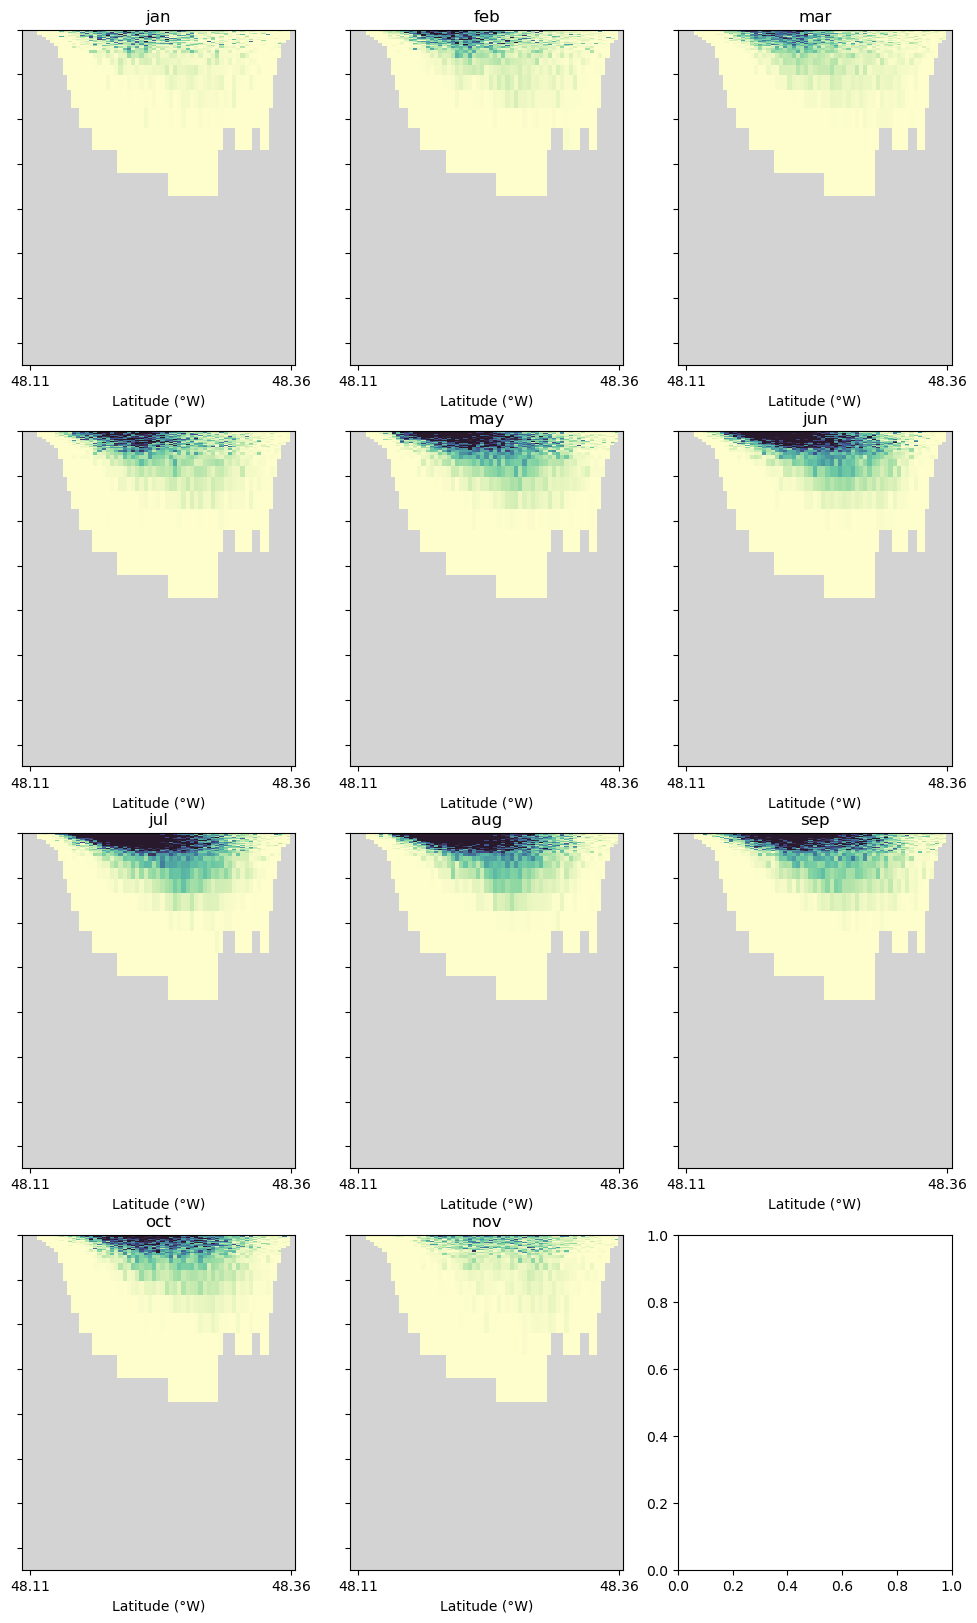

In [ ]:
lonWpr = 260
lonEpr = 310
latpr = 386
lonWros=283
lonEros=305
latros = 267
lonWvs = 235
lonEvs = 301
latvs = 166


fig,[[ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9],[ax10,ax11,ax12]] = plt.subplots(4,3,figsize=(12,20))

for ii,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]):
    plotCS_NW(ax,ddd['forpr_ros3']['final_lat'][4][months[ii]],ddd['forpr_ros3']['final_z'][4][months[ii]],ddd['forpr_ros3']['final_transp'][4][months[ii]],lonWvs,lonEvs,latvs,38,0.02,23*30,months[ii],False,False)



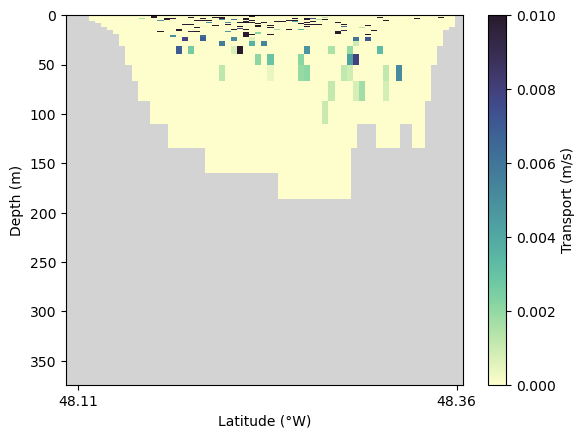

In [ ]:
fig,ax = plt.subplots()
plotCS_NW(ax,dict_secdata['forpr_ros3'][4]['01jan18']['final_lat'],dict_secdata['forpr_ros3'][4]['01jan18']['final_z'],dict_secdata['forpr_ros3'][4]['01jan18']['final_transp'].values,lonWvs,lonEvs,latvs,38,0.01,23,'',True,True)